<a href="https://colab.research.google.com/github/khal-drog0/Breast_Cancer_Histopathology_Classification/blob/main/BeforeVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip3 install -q kaggle

from google.colab import files
files.upload()

! mkdir ~/.kaggle

! cp kaggle.json /root/.kaggle

! chmod 600 /root/.kaggle/kaggle.json

! kaggle datasets download -d paultimothymooney/breast-histopathology-images

! unzip breast-histopathology-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1551_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1601_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1651_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1701_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1751_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1801_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1851_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1901_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1951_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2001_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2251_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2301_class0.png  
  inflating: IDC_regular_

In [1]:
import numpy as np
import pandas as pd
import os
import itertools
import os, stat, time
from os.path import dirname as up
import shutil
import glob
from PIL import Image

In [2]:
from glob import glob
data = glob('../IDC_regular_ps50_idx5/**/*.png', recursive = True)

In [3]:
import cv2
import matplotlib.pyplot as plt

for i in data[:5]:
    img = cv2.imread(i)
    img_1 = cv2.resize(img, (200, 200))
    plt.imshow(img_1, cmap = 'binary')
    plt.show()

In [4]:
import random

def randomSamples(imageData):
    lst = list()
    while(len(lst) != 15000):
        a = random.choice(imageData)

        if a not in lst:
            lst.append(a)

    return lst

In [5]:
import cv2
import matplotlib.pyplot as plt

images = list()
labels = list()
newData = list()

newData = randomSamples(data)

for i in newData:
    if i.endswith('.png'):
        label = i[-5]
        img = cv2.imread(i)
        img_1 = cv2.resize(img, (100, 100))
        images.append(img_1)
        labels.append(label)

IndexError: list index out of range

In [ ]:
len(images)

15000

In [ ]:
x = np.stack(images)

In [ ]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(labels)

In [ ]:
x = x / 255

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 0, test_size = 0.2)

In [ ]:
print('len(x_train):', len(x_train))
print('len(x_test):', len(x_test))
print('len(y_train):', len(y_train))
print('len(y_test):', len(y_test))

len(x_train): 12000
len(x_test): 3000
len(y_train): 12000
len(y_test): 3000


# Building the Neural Network

In [ ]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import models, layers

# model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2()

def modelEfficientNetB0():
    model = models.Sequential()
    # model.add(EfficientNetB0(include_top = False, weights = 'imagenet', input_shape = (100, 100, 3)))
    model.add(InceptionResNetV2(include_top = False, weights = 'imagenet', input_shape = (100, 100, 3)))
    model.add(layers.Dropout(0.05))
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.05))
    model.add(layers.Dense(2, activation = 'sigmoid'))

    return model

model = modelEfficientNetB0()
model.summary()

219070464/219055592 [==============================] - 4s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 1, 1, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d_1   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 2)                 3074      
                                                                 
Total params: 54,339,810
Trainable params: 54,279,266
Non-trainable params: 60,544
_________________________________________________________________


In [ ]:
from tensorflow.keras.optimizers import Adam

opt = Adam(lr = 0.00001, beta_1 = 0.9, beta_2 = 0.999, epsilon = None, decay = 0.0, amsgrad =  False)
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# Training the model

In [ ]:
history = model.fit(x, y, epochs = 50, validation_split = 0.4, batch_size = 56)

Epoch 1/100
161/161 [==============================] - 134s 669ms/step - loss: 0.6310 - acc: 0.6517 - val_loss: 0.5906 - val_acc: 0.7450
Epoch 2/100
161/161 [==============================] - 99s 615ms/step - loss: 0.5167 - acc: 0.7749 - val_loss: 0.7465 - val_acc: 0.7875
Epoch 3/100
161/161 [==============================] - 93s 577ms/step - loss: 0.4621 - acc: 0.7994 - val_loss: 1.1484 - val_acc: 0.8113
Epoch 4/100
161/161 [==============================] - 93s 578ms/step - loss: 0.4217 - acc: 0.8207 - val_loss: 0.8493 - val_acc: 0.8287
Epoch 5/100
161/161 [==============================] - 99s 615ms/step - loss: 0.4035 - acc: 0.8258 - val_loss: 0.9342 - val_acc: 0.8355
Epoch 6/100
161/161 [==============================] - 93s 577ms/step - loss: 0.3813 - acc: 0.8382 - val_loss: 1.2208 - val_acc: 0.8388
Epoch 7/100
161/161 [==============================] - 99s 616ms/step - loss: 0.3667 - acc: 0.8440 - val_loss: 1.5024 - val_acc: 0.8407
Epoch 8/100
161/161 [==========================

# Evaluating the model

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test)

94/94 [==============================] - 12s 118ms/step - loss: 0.3933 - acc: 0.9407


In [ ]:
# Save the model
model.save('before.h5')
# new_model = tensorflow.keras.models.load_model('before.h5')
# new_model.summary()

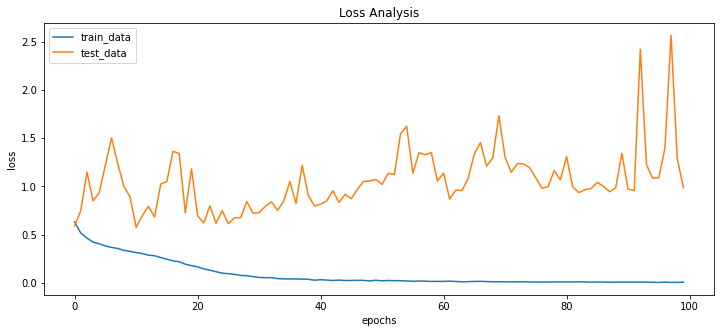

In [ ]:
plt.figure(figsize = (12, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train_data', 'test_data'])
plt.title('Loss Analysis')
plt.show()

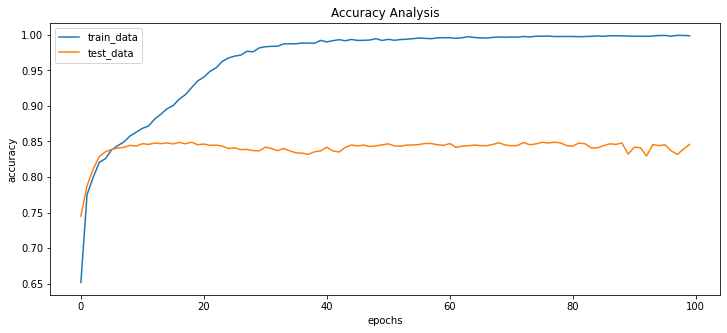

In [ ]:
plt.figure(figsize = (12, 5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train_data', 'test_data'])
plt.title('Accuracy Analysis')
plt.show()

# Testing with random inputs

In [ ]:
IMG = Image.open('9383/0/9383_idx5_x1001_y1501_class0.png')
print(type(IMG))

IMG = IMG.resize((100, 100))
IMG = np.array(IMG)
print('po array = {}'.format(IMG.shape))

IMG = np.true_divide(IMG, 255)
IMG = IMG.reshape(-1, 100, 100, 3)
print(type(IMG), IMG.shape)

y_prob = model.predict(x) 
y_classes = y_prob.argmax(axis=-1)

# predictions = model.predict_classes(IMG)
print(model)
print(y_classes)

# predictions_c = model.predict_classes(IMG)
# print(predictions, predictions_c)

# model.predict_classes(IMG)
model.predict(IMG)
# print(predictions_c)

<class 'PIL.PngImagePlugin.PngImageFile'>
po array = (100, 100, 3)
<class 'numpy.ndarray'> (1, 100, 100, 3)


In [ ]:
classes = {'TRAIN': ['Non Malignant (No Cancer)','Malignant'],
           'TEST': ['Non Malignant (No Cancer)', 'Malignant']}

predicted_class = classes['TRAIN'][predicitions_c[0]]
print('We think that is {}'.format(predicted_class.lower()))

NameError: ignored

# Saving the model

In [ ]:
model.save_weights('_beforeVAE_.h5')

model_json = model.to_json()
with open('_beforeVAE_.json', 'w') as json_file:
    json_file.write(model_json)

print('Model saved to the disk.')